# Explore data

In [13]:
import pandas as pd
import numpy as np
from icecream import ic
import datetime

In [14]:
data_prefix = "mettefrederiksen"

In [15]:
filename = "../" + data_prefix + "_vis.csv"
df = pd.read_csv(filename)
df = df.sort_values("created_at")
df.head()

,index,created_at,id,text,search_keyword,date,mentioneless_text,text50,dupe50,neg,neu,pos,compound
0,0,2020-02-01 09:16:56+00:00,1.223536e+18,@Mettetweeter Arh - jeg synes egentlig ikke de...,['mette frederiksen'],2020-02-01,Arh - jeg synes egentlig ikke det er sjovt. H...,Arh - jeg synes egentlig ikke det er sjovt. H...,False,0.115,0.885,0.00,-0.3570
1,1,2020-02-01 09:21:23+00:00,1.223537e+18,Der er 51% Der gerne vil ifg. Mette Fredriksen...,['mette fredriksen'],2020-02-01,Der er 51% Der gerne vil ifg. Mette Fredriksen...,Der er 51% Der gerne vil ifg. Mette Fredriksen...,False,0.000,1.000,0.00,0.0000
2,2,2020-02-01 12:27:04+00:00,1.223584e+18,"Du tager helt fejl, Morten Østergaard @oesterg...",['mette frederiksen'],2020-02-01,"Du tager helt fejl, Morten Østergaard - Mette...","Du tager helt fejl, Morten Østergaard - Mette...",False,0.167,0.683,0.15,-0.0937
3,3,2020-02-01 12:46:14+00:00,1.223588e+18,Mette Frederiksen og @JeppeKofod skal finde al...,['mette frederiksen'],2020-02-01,Mette Frederiksen og skal finde alliancepartn...,Mette Frederiksen og skal finde alliancepartn...,False,0.000,1.000,0.00,0.0000
4,4,2020-02-01 17:12:31+00:00,1.223655e+18,#MetteF ( @Spolitik ) er KUN #statsminister FO...,['mettef'],2020-02-01,( ) er KUN FOR 2 børn - hendes egne...,( ) er KUN FOR 2 børn - hendes egne...,False,0.211,0.789,0.00,-0.3399


In [16]:
df["date"] = pd.to_datetime(df["created_at"], utc=True).dt.strftime('%Y-%m-%d')
df["date"] = pd.to_datetime(df["date"])


start_date = "2021-01-01" #datetime.date(2021, 1, 1)
mask2021 = (df['date'] >= start_date)
mask2020 = (df['date'] < start_date)
mask2020winter = (df['date'] < "2021-01-01") & (df['date'] >= "2020-11-01")

ic(len(df.loc[mask2021]))
ic(len(df.loc[mask2020winter]))
ic(len(df.loc[mask2020]))

ic| len(df.loc[mask2021]): 8670
ic| len(df.loc[mask2020winter]): 6314
ic| len(df.loc[mask2020]): 16548


16548

## Tweet frequency over time

In [17]:
# Aggregate a frequency DF
def get_tweet_frequencies(df):
    tweet_freq = pd.DataFrame({'nr_of_tweets' : df.groupby(['date']).size()}).reset_index()
    freq_tweets = pd.merge(df, tweet_freq, how='left', on=['date'])#, 'id', 'created_at'])
    return freq_tweets

In [18]:
df["date"] = pd.to_datetime(df["created_at"], utc=True).dt.strftime('%Y-%m-%d')

freq_df = get_tweet_frequencies(df)

In [19]:
print(freq_df.loc[mask2021].nr_of_tweets.describe())
print(freq_df.loc[mask2020winter].nr_of_tweets.describe())

count    8670.000000
mean       93.143714
std        55.639386
min        14.000000
25%        56.000000
50%        75.000000
75%       104.000000
max       260.000000
Name: nr_of_tweets, dtype: float64
count    6314.000000
mean      153.835287
std        86.649230
min        10.000000
25%        89.000000
50%       143.000000
75%       193.000000
max       362.000000
Name: nr_of_tweets, dtype: float64


In [20]:
freq_df.nr_of_tweets.describe()

count    25218.000000
mean        98.002617
std         71.957293
min          3.000000
25%         43.000000
50%         77.000000
75%        142.000000
max        362.000000
Name: nr_of_tweets, dtype: float64

In [21]:
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pyplot_themes as themes
import datetime as dt

In [22]:
freq_df["date"] = pd.to_datetime(freq_df["date"])
freq_df['date_ordinal'] = pd.to_datetime(freq_df['date']).apply(lambda date: date.toordinal())

In [23]:
# Add gaussian smoothing
def gaussian_kernel(arr, sigma=False, fwhm=False):
    """ gaussian kernel smoother for signal arr
    - sigma: standard deviation of gaussian distribution
    - fwhm: full width at half maximum of gaussian distribution
    """
    y_vals = np.array(arr)
    x_vals = np.arange(arr.shape[0])
    if sigma == fwhm:
        print("[INFO] Define parameters \u03C3 xor FWHM")
        pass
    elif fwhm:
        sigma = fwhm / np.sqrt(8 * np.log(2))
    else:
        sigma = sigma
        fwhm = sigma * np.sqrt(8 * np.log(2))
    print("[INFO] Applying Gaussian kernel for \u03C3 = {} and FWHM = {} ".format(round(sigma,2), round(fwhm,2)))
    smoothed_vals = np.zeros(y_vals.shape)
    for x_position in x_vals:
        kernel = np.exp(-(x_vals - x_position) ** 2 / (2 * sigma ** 2))
        kernel = kernel / sum(kernel)
        smoothed_vals[x_position] = sum(y_vals * kernel)
    return smoothed_vals

In [34]:
freq_df["smooth"] = gaussian_kernel(freq_df["nr_of_tweets"], sigma = 1, fwhm = 500)

[INFO] Applying Gaussian kernel for σ = 212.33 and FWHM = 500 


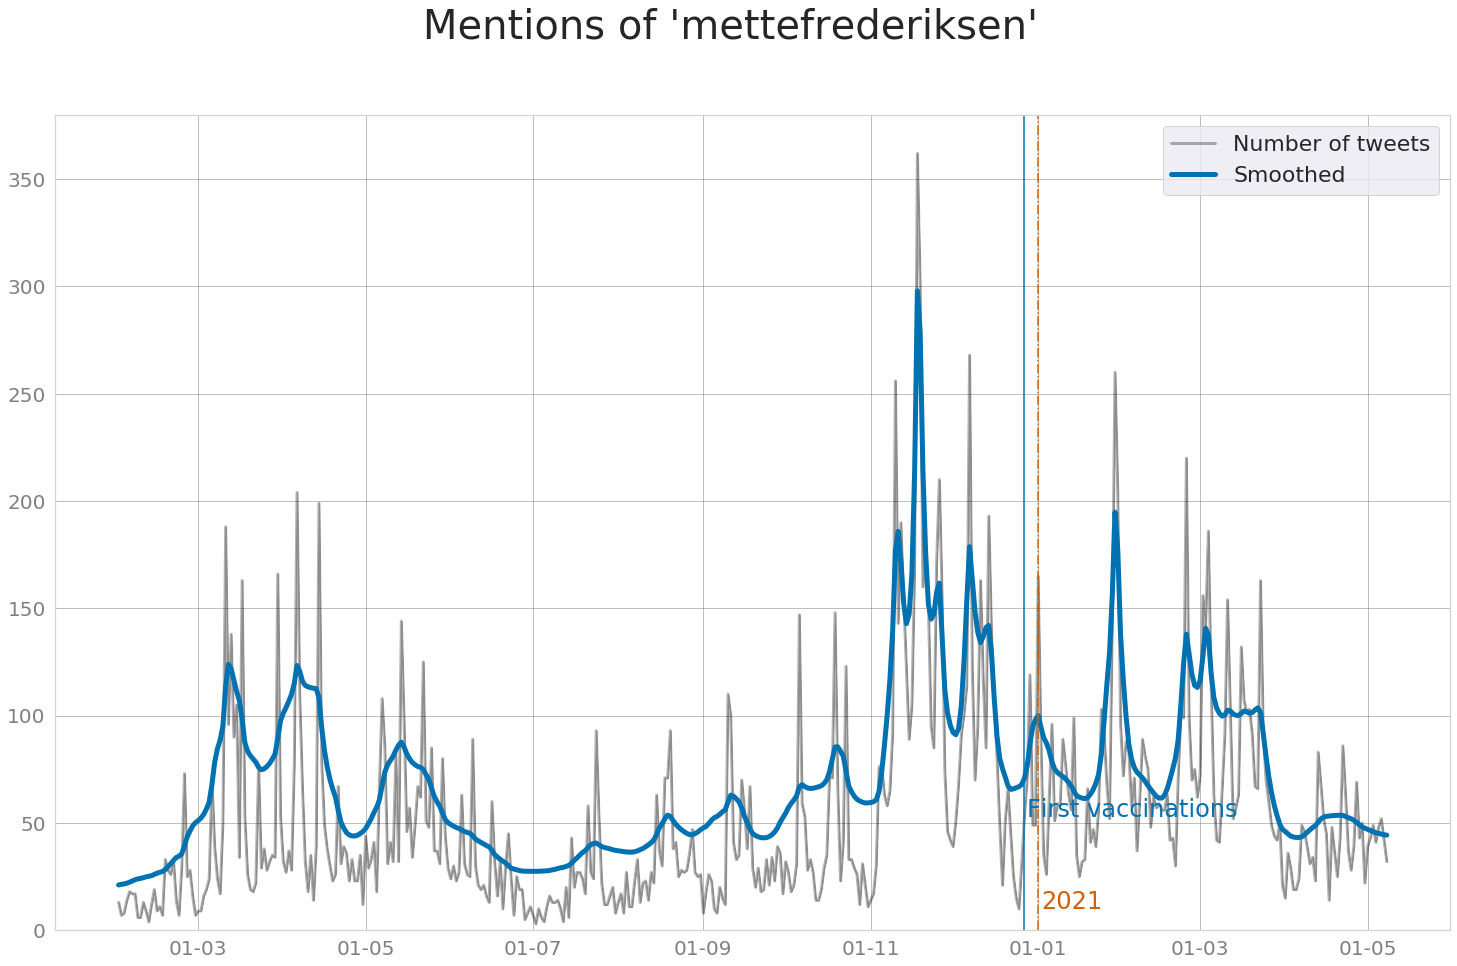

In [35]:
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('xtick', labelsize=20)

nr_colors = len(freq_df["date"].unique())

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)

palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

fig, (ax1) = plt.subplots(1,1, figsize=a4_dims)
sns.set(font_scale = 2)
ax1 = sns.lineplot(x="date", y="nr_of_tweets", 
                  color = palette[0], 
                   alpha = 0.30,
                   label = "Number of tweets",
                     linewidth = 3, data = freq_df)

ax1 = sns.lineplot(x="date", y="smooth", 
                  color = palette[5], 
                   label = "Smoothed",
                     linewidth = 5, data = freq_df)


ax1.set(xlabel="", ylabel = "")
ax1.xaxis.get_label().set_fontsize(40)
ax1.yaxis.get_label().set_fontsize(40)

ax1.grid(color='grey', linestyle='-', linewidth=0.5, which= "both")

plt.axvline(dt.datetime(2021, 1, 1), color=palette[6], linestyle = "dashdot")
plt.text(x = dt.datetime(2021, 1, 2), 
 y = 10,
 s = '2021',
 color = palette[6])

plt.axvline(dt.datetime(2020, 12, 27), color=palette[5])
plt.text(x = dt.datetime(2020, 12, 28),
 y = freq_df[freq_df["date"] == "2020-12-27"]["nr_of_tweets"].reset_index(drop=True)[0], # y-coordinate position of data label, to take max height 
 s = 'First vaccinations',
 color = palette[5])

# Define the date format
ax1.xaxis_date()
date_form = mdates.DateFormatter("%d-%m")
ax1.xaxis.set_major_formatter(date_form)

ax1.set(ylim=(0, None))
title = "Mentions of '" + data_prefix + "'"
fig.suptitle(title, size = "40")

#plot_name = "fig/all_vaccin_mentions.png"
#fig.savefig(plot_name)

fig.show()

In [36]:
# Now from 1.11 - now
freq_df["date"] = pd.to_datetime(df["date"])
mask = (freq_df['date'] >= '2020-11-01')
wfreq_df = freq_df.loc[mask]

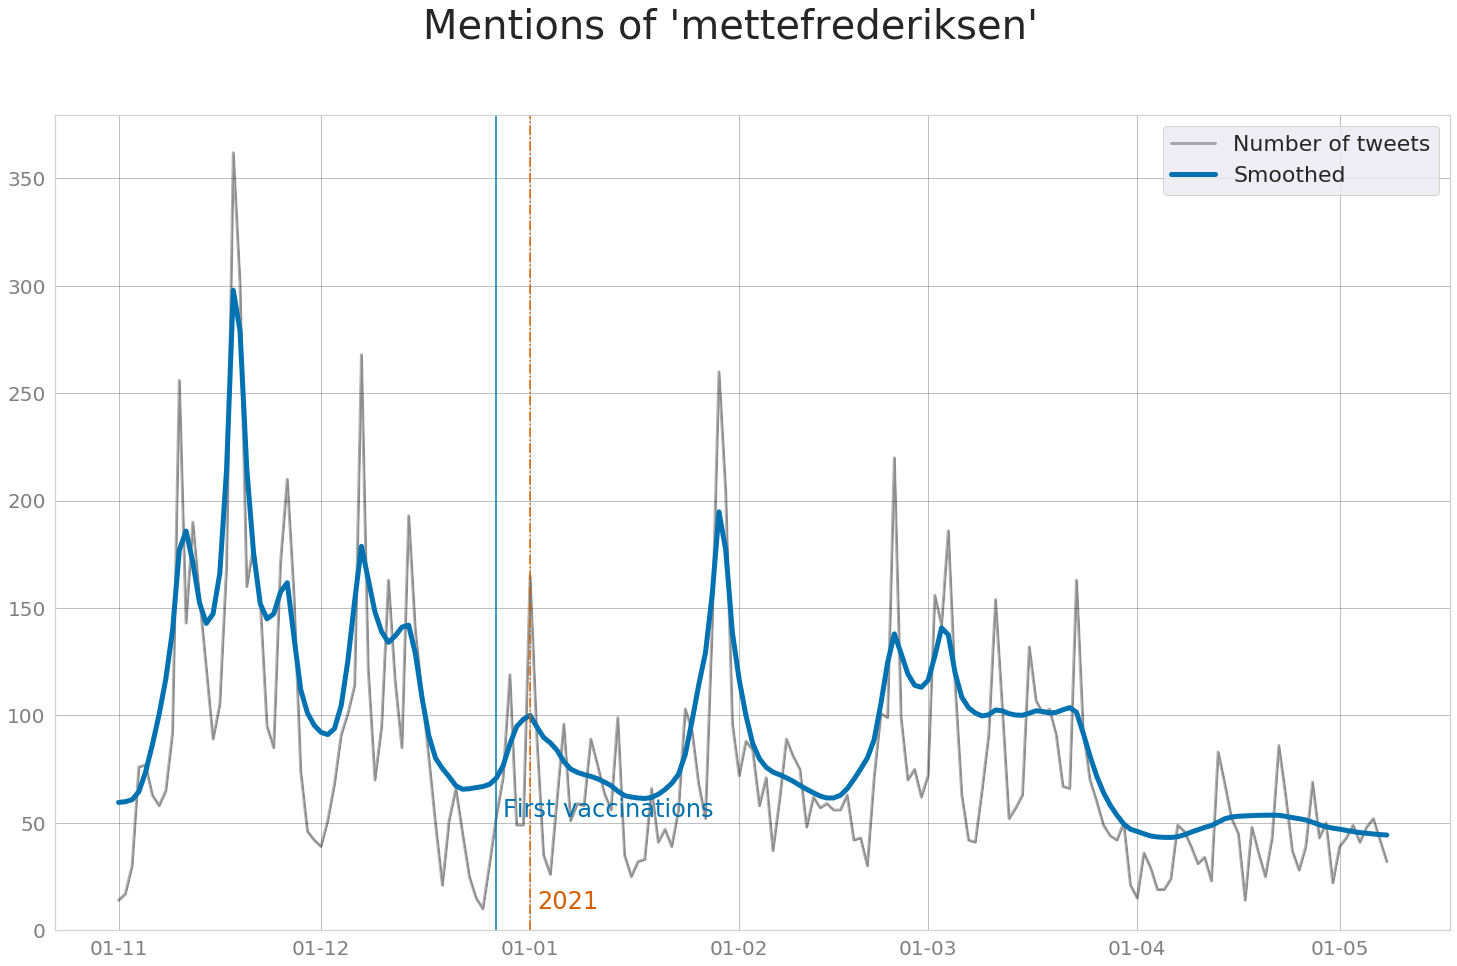

In [37]:
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('xtick', labelsize=20)

nr_colors = len(freq_df["date"].unique())

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)

palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

fig, (ax1) = plt.subplots(1,1, figsize=a4_dims)
sns.set(font_scale = 2)


ax1 = sns.lineplot(x="date", y="nr_of_tweets", 
                  color = palette[0], 
                   alpha = 0.30,
                   label = "Number of tweets",
                     linewidth = 3, data = wfreq_df)

ax1 = sns.lineplot(x="date", y="smooth", 
                  color = palette[5], 
                   label = "Smoothed",
                     linewidth = 5, data = wfreq_df)


ax1.set(xlabel="", ylabel = "")
ax1.xaxis.get_label().set_fontsize(40)
ax1.yaxis.get_label().set_fontsize(40)

ax1.grid(color='grey', linestyle='-', linewidth=0.5, which= "both")

plt.axvline(dt.datetime(2021, 1, 1), color=palette[6], linestyle = "dashdot")
plt.text(x = dt.datetime(2021, 1, 2), # x-coordinate position of data label, adjusted to be 3 right of the data point
 y = 10,#freq_df[freq_df["date"] == "2021-01-02"]["nr_of_tweets"].reset_index(drop=True)[0], # y-coordinate position of data label, to take max height 
 s = '2021', # data label
 color = palette[6])

plt.axvline(dt.datetime(2020, 12, 27), color=palette[5])
plt.text(x = dt.datetime(2020, 12, 28), # x-coordinate position of data label, adjusted to be 3 right of the data point
 y = freq_df[freq_df["date"] == "2020-12-27"]["nr_of_tweets"].reset_index(drop=True)[0], # y-coordinate position of data label, to take max height 
 s = 'First vaccinations', # data label
 color = palette[5])

# Define the date format
ax1.xaxis_date()
date_form = mdates.DateFormatter("%d-%m")
ax1.xaxis.set_major_formatter(date_form)

ax1.set(ylim=(0, None))
title = "Mentions of '" + data_prefix + "'"
fig.suptitle(title, size = "40")

#plot_name = "fig/all_vaccin_mentions_winter.png"
#fig.savefig(plot_name)

fig.show()

## Separate positive and negative tweets

In [12]:
average_compound = sum(df["compound"]) / len(df["compound"])
df["centered_compound"] = df["compound"] - average_compound

neg = df[df["centered_compound"] < 0]
pos = df[df["centered_compound"] > 0]
neu = df[df["centered_compound"] == 0]

ic(len(neg))
ic(len(pos))
ic(len(neu))

ic| len(neg): 41212
ic| len(pos): 39654
ic| len(neu): 0


0

# Hashtags

In [13]:
import re

def extract_hashtags(row):
    unique_hashtag_list = list(re.findall(r'#\S*\w', row["text"]))
    return unique_hashtag_list

def hashtag_per_row(data):
    # Create hashtags column with the actual unique hashtags
    data["hashtags"] = data.apply(lambda row: extract_hashtags(row), axis = 1)

    # Let's take a subset of necessary columns, add id
    df = data[["date", "hashtags"]].reset_index().rename(columns={"index": "id"})

    # Select only the ones where we have more than 1 hashtag per tweet
    df = df[df["hashtags"].map(len) > 1].reset_index(drop=True)

    # Hashtag per row
    # convert list of pd.Series then stack it
    df = (df
     .set_index(['date','id'])['hashtags']
     .apply(pd.Series)
     .stack()
     .reset_index()
     .drop('level_2', axis=1)
     .rename(columns={0:'hashtag'}))
    #lowercase!
    df["hashtag"] = df["hashtag"].str.lower()
    df["hashtag"] = df["hashtag"].str.replace("'.", "")
    df["hashtag"] = df["hashtag"].str.replace("’.", "")

    return df

hashtags = hashtag_per_row(freq_df)
neg_hashtags = hashtag_per_row(neg)
pos_hashtags = hashtag_per_row(pos)

/home/commando/maris/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/commando/maris/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [14]:
# Aggregate a frequency DF
def get_hashtag_frequencies(df):
    # Add freq of hashtags by themselves in the dataset
    tweet_freq = pd.DataFrame({'nr_of_hashtags' : df.groupby(['hashtag']).size()}).reset_index()
    return tweet_freq

In [15]:
freq_hashtags = get_hashtag_frequencies(hashtags)
df1 = freq_hashtags.sort_values(by=['nr_of_hashtags'], ascending=False)

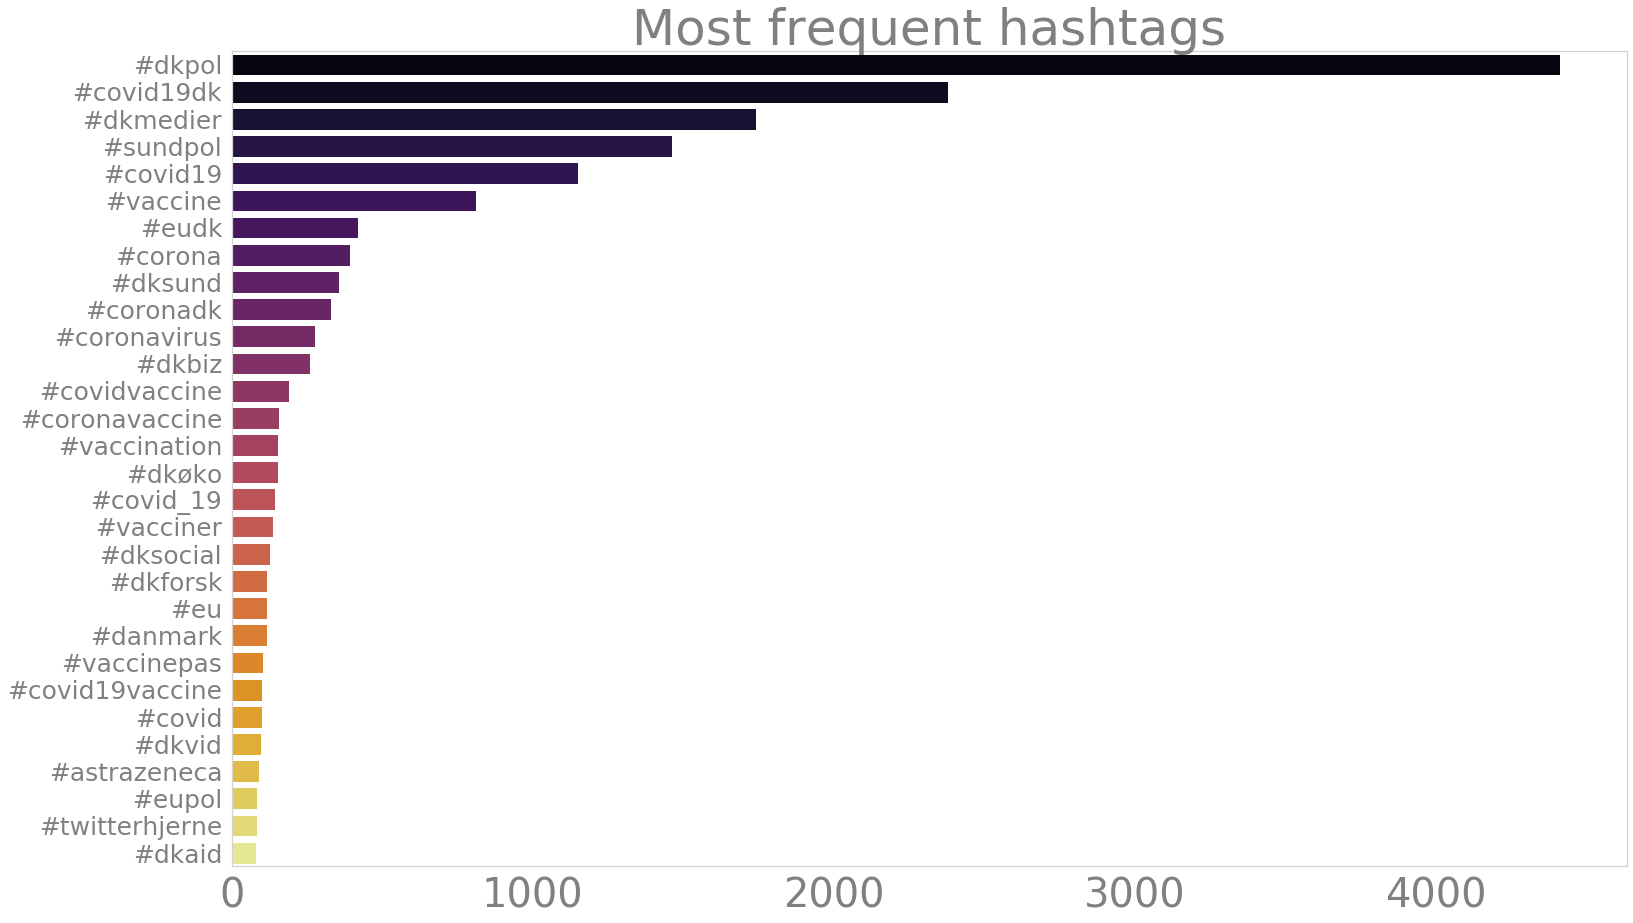

In [16]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pyplot_themes as themes

matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('xtick', labelsize=20)

df0 = df1.nlargest(30, columns=['nr_of_hashtags'])
nr_hash = len(df0["hashtag"].unique())
themes.theme_minimal(grid=False, ticks=False, fontsize=40)

a4_dims = (25,15) #(11.7, 8.27)
fig, (ax) = plt.subplots(1,1, figsize=a4_dims)

palette = sns.color_palette("inferno", nr_hash)

ax = sns.barplot(y="hashtag", x="nr_of_hashtags", palette = palette, data = df0)

ax.set(xlabel="Count", ylabel = "Hashtag")
ax.xaxis.get_label().set_fontsize(25)
ax.yaxis.get_label().set_fontsize(25)
ax.axes.set_title("Most frequent hashtags",fontsize=50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=25)

ax.set(xlabel="", ylabel = "")
ax.xaxis.get_label().set_fontsize(100)
ax.yaxis.get_label().set_fontsize(40)

ax.grid(color='white', linestyle='-', linewidth=0.5, which= "both")

plot_name = "fig/frequent_hashtags.png"
fig.savefig(plot_name, bbox_inches='tight')

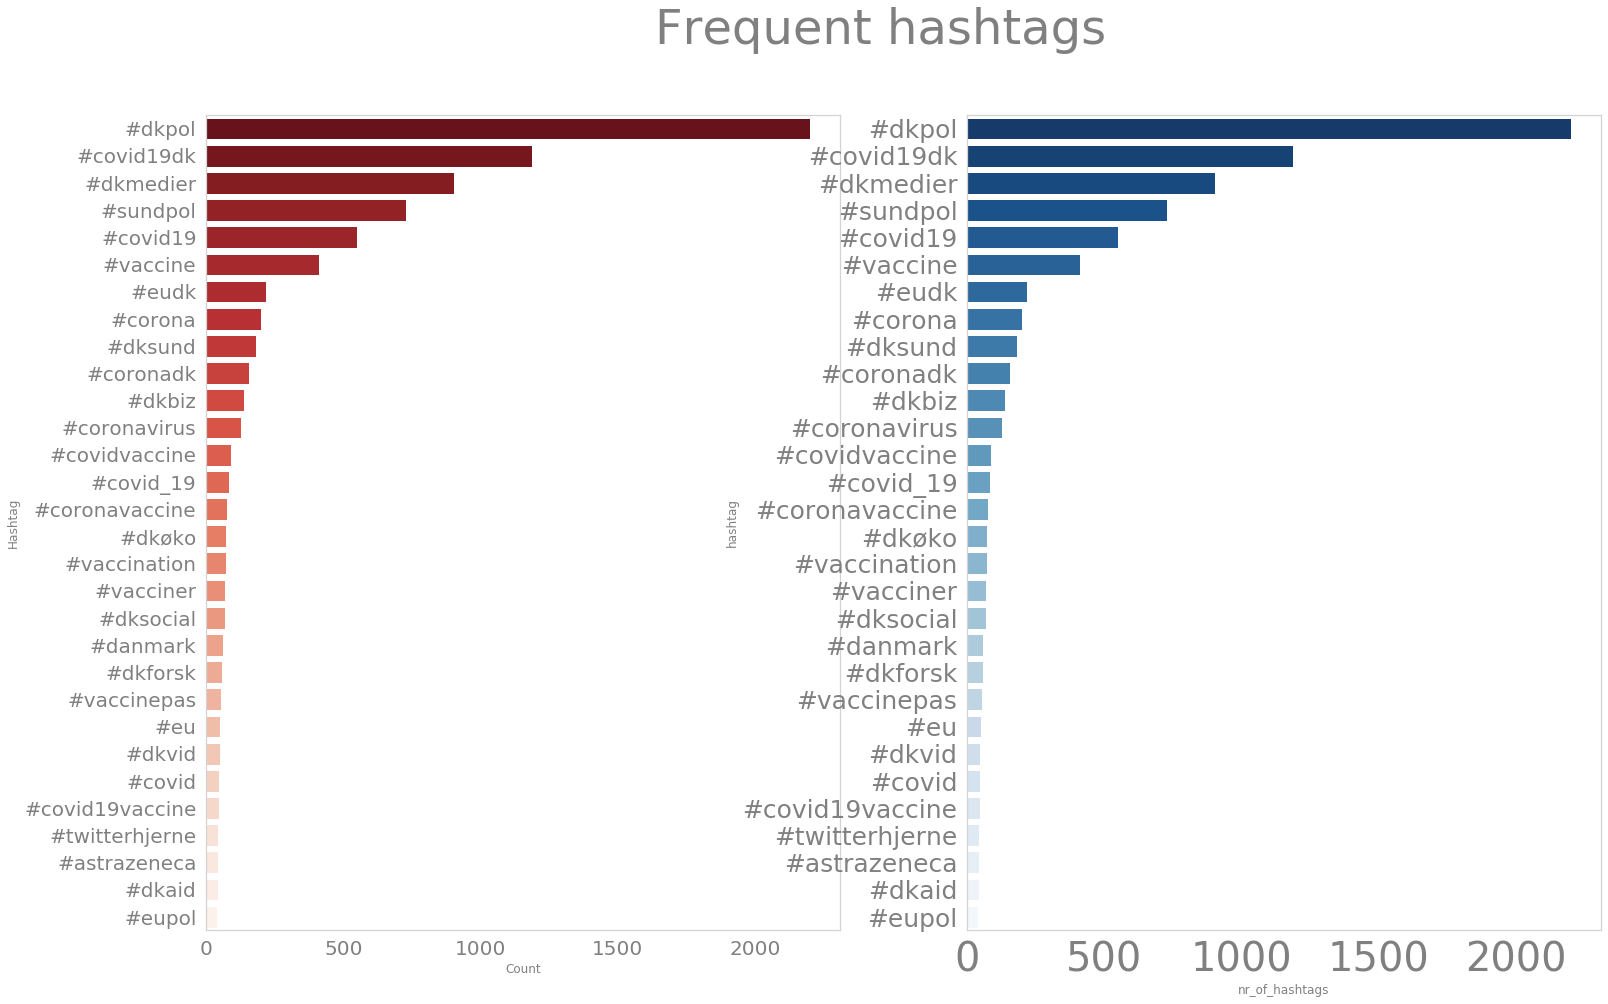

In [17]:
freq_hashtags = get_hashtag_frequencies(neg_hashtags)
df1 = freq_hashtags.sort_values(by=['nr_of_hashtags'], ascending=False)
df0 = df1.nlargest(30, columns=['nr_of_hashtags'])

freq_hashtags = get_hashtag_frequencies(pos_hashtags)
df11 = freq_hashtags.sort_values(by=['nr_of_hashtags'], ascending=False)
df00 = df1.nlargest(30, columns=['nr_of_hashtags'])

matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('xtick', labelsize=20)

nr_hash = len(df0["hashtag"].unique())
themes.theme_minimal(grid=False, ticks=False, fontsize=40)

a4_dims = (25,15) #(11.7, 8.27)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=a4_dims)

palette = sns.color_palette("Blues_r", nr_hash)

ax1 = sns.barplot(y="hashtag", x="nr_of_hashtags", palette="Reds_r", data = df0, ax=ax1)
ax2 = sns.barplot(y="hashtag", x="nr_of_hashtags", palette = "Blues_r", data = df00, ax=ax2)

ax1.set(xlabel="Count", ylabel = "Hashtag")
ax.xaxis.get_label().set_fontsize(25)
ax.yaxis.get_label().set_fontsize(25)
ax.axes.set_title("Most frequent hashtags",fontsize=50)

fig.suptitle("Frequent hashtags")

plt.xticks(fontsize=40)
plt.yticks(fontsize=25)

ax.set(xlabel="", ylabel = "")
ax.xaxis.get_label().set_fontsize(100)
ax.yaxis.get_label().set_fontsize(40)

ax.grid(color='white', linestyle='-', linewidth=0.5, which= "both")

plot_name = "fig/frequent_hashtags_neg_pos.png"
fig.savefig(plot_name, bbox_inches='tight')

In [18]:
df0["sent"] = "neg"
df00["sent"] = "pos"

In [19]:
one = list(df0["hashtag"])
two = list(df00["hashtag"])

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

print(intersection(one, two))

['#dkaid', '#dkforsk', '#eupol', '#vaccination', '#dkpol', '#vaccine', '#dkøko', '#sundpol', '#astrazeneca', '#dkbiz', '#twitterhjerne', '#eu', '#covid_19', '#dkmedier', '#coronadk', '#dksund', '#corona', '#covid19vaccine', '#vacciner', '#dkvid', '#covidvaccine', '#coronavaccine', '#coronavirus', '#eudk', '#danmark', '#covid19', '#dksocial', '#covid19dk', '#covid', '#vaccinepas']


In [20]:
# Unique words
list(set(one).symmetric_difference(set(two)))

[]

In [23]:
per_date = hashtags[['date', 'id', 'hashtag']].groupby(['date', 'hashtag']).agg(['count']).reset_index()
per_date["hashtag_per_date"] = per_date["id"]["count"]
per_date = per_date[["date", "hashtag", "hashtag_per_date"]]
per_date = per_date.rename(columns={"hashtag": "Hashtag"})

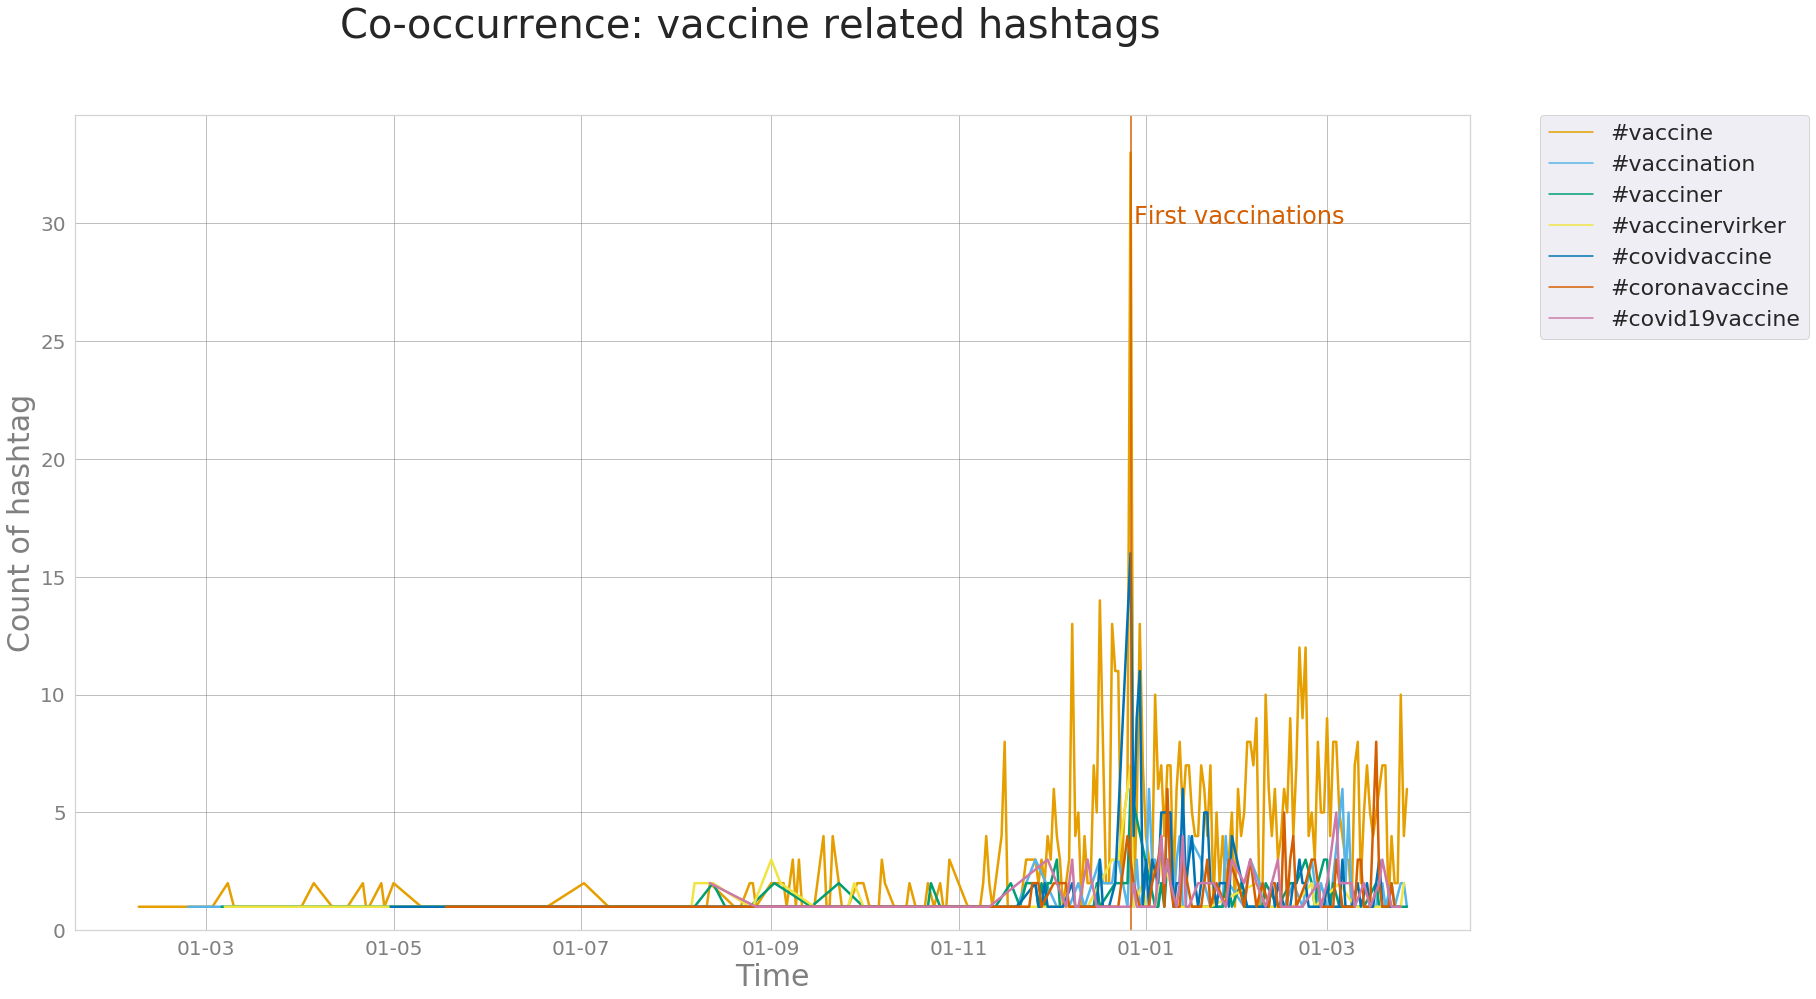

In [24]:
df0 = per_date.loc[per_date['Hashtag'].isin(['#vaccine', "#covidvaccine", "#vaccination", "#coronavaccine", "#vacciner", "#covid19vaccine", "#vaccinervirker"])].reset_index(drop=False)
nr_hash = len(df0["Hashtag"].unique())

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)

#palette = sns.color_palette("inferno", nr_hash)
palette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]


fig, ax = plt.subplots(figsize=a4_dims)
sns.set(font_scale = 2)

ax = sns.lineplot(x="date", y="hashtag_per_date", 
                  hue="Hashtag", style="Hashtag", 
                  #markers = True, markersize = 10, 
                  dashes = False, 
                  palette = palette, 
                  linewidth = 2.5, data = df0)

ax.set(xlabel="Time", ylabel = "Count of hashtag")
ax.xaxis.get_label().set_fontsize(30)
ax.yaxis.get_label().set_fontsize(30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.grid(color='grey', linestyle='-', linewidth=0.5, which= "both")

plt.axvline(dt.datetime(2020, 12, 27), color=palette[5])
plt.text(x = dt.datetime(2020, 12, 28), # x-coordinate position of data label, adjusted to be 3 right of the data point
 y = 30, #df0[df0["date"] == "2020-12-27"]["hashtag_per_date"].reset_index(drop=True)[0], # y-coordinate position of data label, to take max height 
 s = 'First vaccinations', # data label
 color = palette[5])

#plt.ylim(0, 80)

# Define the date format
ax.xaxis_date()
date_form = mdates.DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)

ax.set(ylim=(0, None))
fig.suptitle('Co-occurrence: vaccine related hashtags', fontsize=40)
#ax1.set_title('Level 1', fontsize=30)

#ax1.legend_.remove()

plot_name = "fig/vaccine_hashtags_over_time.png"
fig.savefig(plot_name, bbox_extra_artists=(lgd,), bbox_inches='tight')

fig.show()

## Wordcloud

In [21]:
import spacy
import string
from string import digits
import re
sp = spacy.load('da_core_news_lg')

file = open("../hope-keyword-templates/src/stop_words.txt","r+")
stop_words = file.read().split()

# Lemmatize stop words
stops = " ".join(stop_words)
stops = sp(stops)
my_stop_words = [t.lemma_ for t in stops]

In [22]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def lemmas(row):
    tweet = row["mentioneless_text"].lower()
    tweet = remove_emoji(tweet)
    tweet = re.sub(r'@(\S*)\w', '', tweet) #mentions
    tweet = re.sub(r'#\S*\w', '', tweet) # hashtags
    # Remove URLs
    url_pattern = re.compile(
        r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')
    tweet = re.sub(url_pattern, '', tweet)
    
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    #tweet = tweet.translate(str.maketrans('', '', digits))
    tweet = tweet.replace('”', '')
    tweet = tweet.replace('“', '')
    
    sentence = sp(tweet)
    lemmas = []
    for word in sentence:
        lemmas.append(word.lemma_)
    res = [x for x in lemmas if x not in my_stop_words]
    hmm = ['   ','  ',' ','','♂','','❤','','🤷']
    res = [x for x in res if x not in hmm]
    return res

#freq_df["tokens_list"] = freq_df.apply(lambda row: lemmas(row), axis = 1)

In [23]:
def join_tokens(row):
    res = " ".join(row["tokens_list"])
    return res

#freq_df["tokens_string"] = freq_df.apply(lambda row: join_tokens(row), axis = 1)
#texts = freq_df["tokens_string"]

In [15]:
word_freq = freq_df.tokens_string.str.split(expand=True).stack().value_counts()

In [16]:
word_freq = word_freq.to_frame().reset_index().rename(columns={"index": "word", 0: "Frequency"})

In [17]:
import string

texts = ", ".join(texts)
texts = texts.translate(str.maketrans('', '', string.punctuation))
texts = texts.lower()

In [18]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pyplot_themes as themes

word_freq = word_freq[~word_freq["word"].isin(stop_words)]
df0 = word_freq.nlargest(30, columns=['Frequency'])
nr_hash = len(df0["word"].unique())

matplotlib.rc('ytick', labelsize=30)
matplotlib.rc('xtick', labelsize=30)

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)

fig, (ax) = plt.subplots(1,1, figsize=a4_dims)

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
palette = sns.color_palette("Blues_r", nr_hash)

ax = sns.barplot(y="word", x="Frequency", palette = palette, data = df0)

ax.set(xlabel="Count", ylabel = "Hashtag")
ax.xaxis.get_label().set_fontsize(25)
ax.yaxis.get_label().set_fontsize(25)
ax.axes.set_title("Most frequent words",fontsize=50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=25)

ax.set(xlabel="", ylabel = "")
ax.xaxis.get_label().set_fontsize(100)
ax.yaxis.get_label().set_fontsize(40)

plot_name = "fig/word_frequency.png"
fig.savefig(plot_name)

NameError: name 'matplotlib' is not defined

## For neg and pos datasets

In [24]:
neg["tokens_list"] = neg.apply(lambda row: lemmas(row), axis = 1)
neg["tokens_string"] = neg.apply(lambda row: join_tokens(row), axis = 1)
neg_word_freq = neg.tokens_string.str.split(expand=True).stack().value_counts()
neg_word_freq = neg_word_freq.to_frame().reset_index().rename(columns={"index": "word", 0: "Frequency"})

pos["tokens_list"] = pos.apply(lambda row: lemmas(row), axis = 1)
pos["tokens_string"] = pos.apply(lambda row: join_tokens(row), axis = 1)
pos_word_freq = pos.tokens_string.str.split(expand=True).stack().value_counts()
pos_word_freq = pos_word_freq.to_frame().reset_index().rename(columns={"index": "word", 0: "Frequency"})

/home/commando/maris/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/commando/maris/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/commando/maris/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



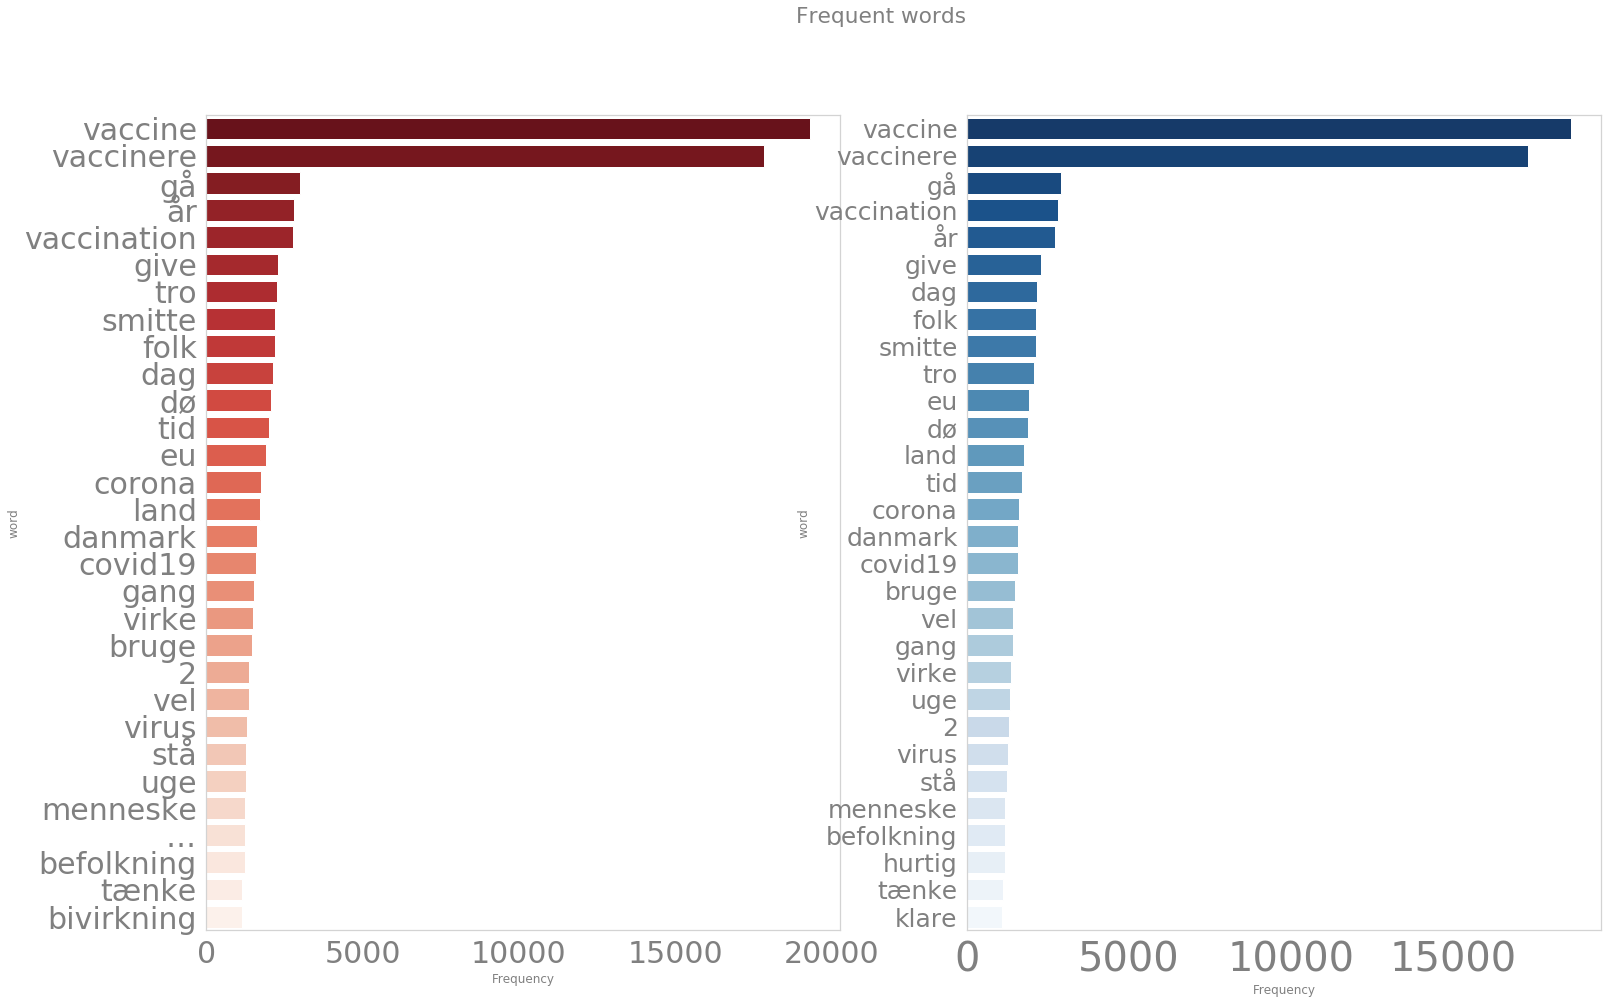

In [25]:
word_freq = neg_word_freq[~neg_word_freq["word"].isin(stop_words)]
df0 = word_freq.nlargest(30, columns=['Frequency'])

word_freq = pos_word_freq[~pos_word_freq["word"].isin(stop_words)]
df00 = word_freq.nlargest(30, columns=['Frequency'])

matplotlib.rc('ytick', labelsize=30)
matplotlib.rc('xtick', labelsize=30)

themes.theme_minimal(grid=False, ticks=False, fontsize=18)
a4_dims = (25,15) #(11.7, 8.27)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=a4_dims)

themes.theme_minimal(grid=False, ticks=False, fontsize=18)

ax1 = sns.barplot(y="word", x="Frequency", palette="Reds_r", data = df0, ax=ax1)
ax2 = sns.barplot(y="word", x="Frequency", palette = "Blues_r", data = df00, ax=ax2)

ax.set(xlabel="Count", ylabel = "Hashtag")
ax.xaxis.get_label().set_fontsize(25)
ax.yaxis.get_label().set_fontsize(25)
ax.axes.set_title("Most frequent words",fontsize=50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=25)

fig.suptitle("Frequent words")


ax.set(xlabel="", ylabel = "")
ax.xaxis.get_label().set_fontsize(100)
ax.yaxis.get_label().set_fontsize(40)

plot_name = "fig/pos_neg_word_frequency.png"
fig.savefig(plot_name, bbox_inches='tight')

In [26]:
one = list(df0["word"])
two = list(df00["word"])

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

print(intersection(one, two))

['covid19', 'tro', 'gå', 'stå', 'virke', 'folk', 'gang', 'år', 'bruge', 'land', 'danmark', 'vaccination', '2', 'virus', 'dø', 'vaccine', 'befolkning', 'menneske', 'smitte', 'give', 'corona', 'uge', 'eu', 'tid', 'vel', 'tænke', 'dag', 'vaccinere']


In [27]:
# Unique words
list(set(one).symmetric_difference(set(two)))

['klare', 'hurtig', 'bivirkning', '…']

## Word cloud

In [33]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    plot_name = "fig/word_cloud.png"
    plt.savefig(plot_name)

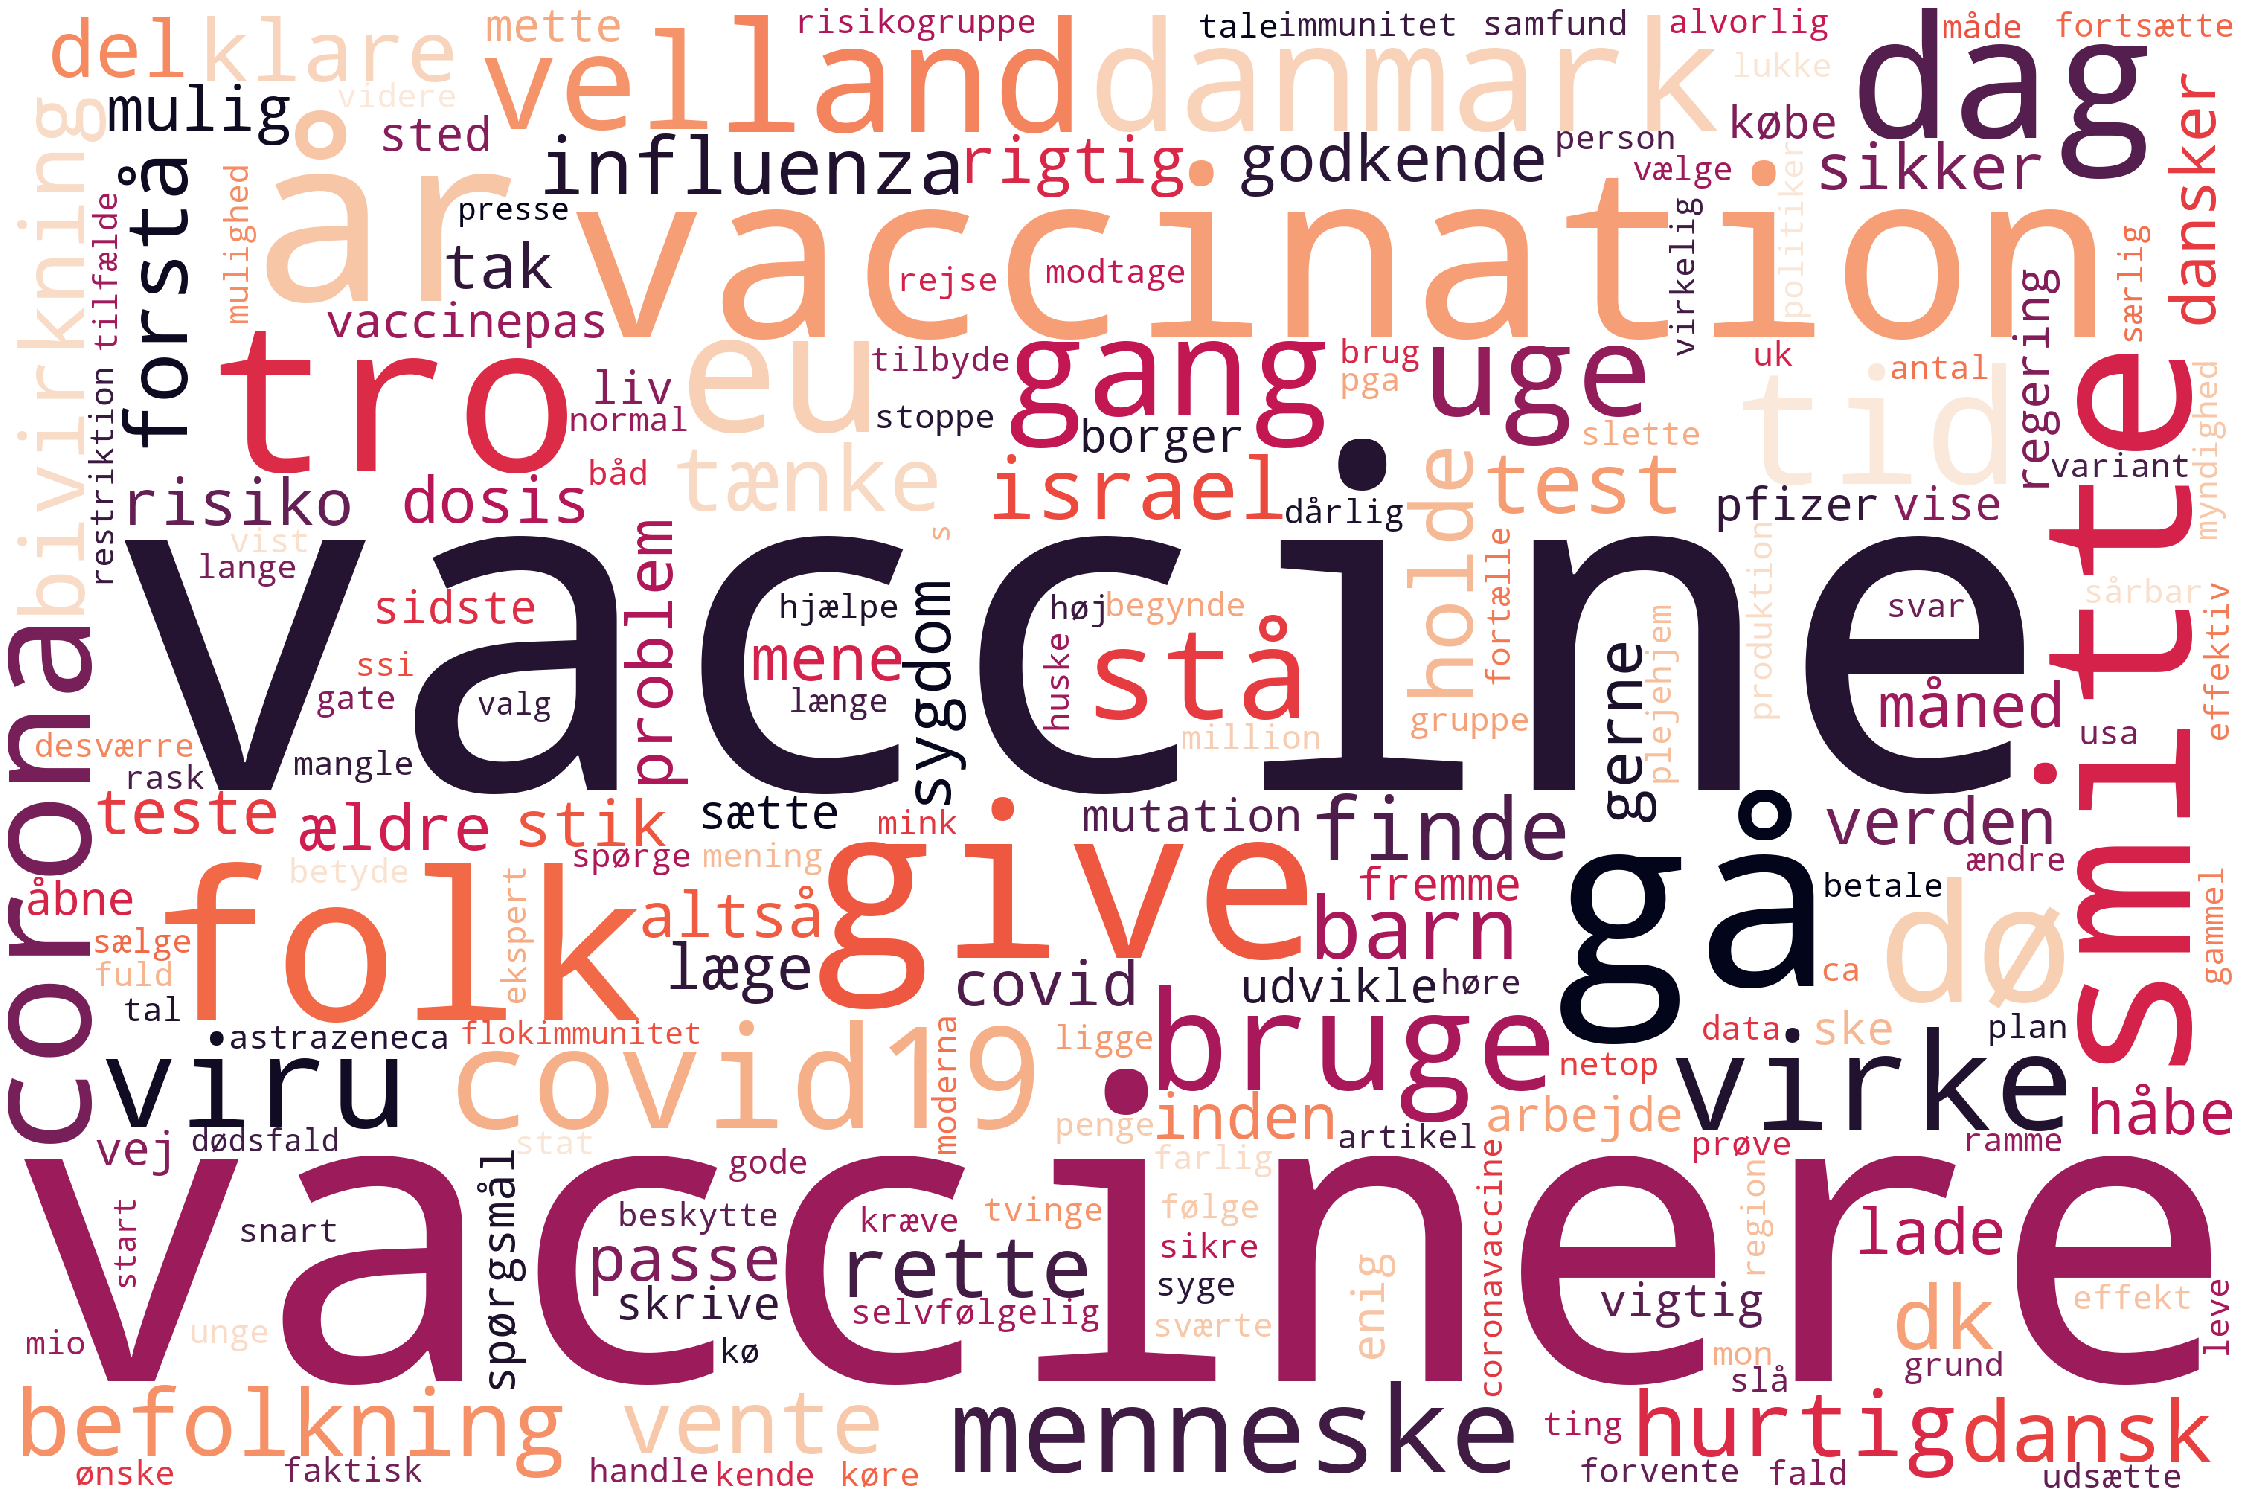

In [34]:
# Import package
from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='white', colormap="rocket", 
                      collocations=False, stopwords = stop_words).generate(texts)
# Plot
plot_cloud(wordcloud)

In [35]:
from nltk import bigrams
import itertools
import collections
import networkx as nx
import spacy
import nltk

In [36]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

#nlp = spacy.load("da_core_news_sm")

%matplotlib inline

In [37]:
freq_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80866 entries, 0 to 80865
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              80866 non-null  int64         
 1   created_at         80866 non-null  object        
 2   id                 80866 non-null  float64       
 3   text               80866 non-null  object        
 4   search_keyword     80866 non-null  object        
 5   neg                80866 non-null  float64       
 6   neu                80866 non-null  float64       
 7   pos                80866 non-null  float64       
 8   compound           80866 non-null  float64       
 9   date               80866 non-null  datetime64[ns]
 10  mentioneless_text  80866 non-null  object        
 11  text50             80866 non-null  object        
 12  dupe50             80866 non-null  bool          
 13  nr_of_tweets       80866 non-null  int64         
 14  date_o

In [38]:
# Create list of lists containing bigrams in tweets
#terms_bigram = list(bigrams(wordlist))
terms_bigram = [list(bigrams(tweet)) for tweet in freq_df['tokens_list']]
#terms_bigram = [list(bigrams(tweet)) for tweet in df['tokens_no_stop']]

# View bigrams for the first tweet
terms_bigram[0]

[('ligge', 'faste'),
 ('faste', 'vel'),
 ('vel', 'donere'),
 ('donere', 'blod'),
 ('blod', 'vaccine')]

In [39]:
# Flatten list of bigrams in clean tweets
bigrams = list(itertools.chain(*terms_bigram))

# Create counter of words in clean bigrams
bigram_counts = collections.Counter(bigrams)

In [40]:
bigram_df = pd.DataFrame(bigram_counts.most_common(30), columns=["bigram", "count"])

bigram_df

,bigram,count
0,"(vaccine, virke)",873
1,"(lade, vaccinere)",676
2,"(give, mening)",609
3,"(covid19, vaccine)",563
4,"(bill, gate)",553
5,"(mette, frederiksen)",429
6,"(dø, vaccine)",428
7,"(udvikle, vaccine)",427
8,"(lange, tid)",419
9,"(’, s)",414


In [44]:
bigram_df = bigram_df.drop([9, 27, 28, 29]).reset_index(drop=True)

In [45]:
bigram_df.head(10)

,bigram,count
0,"(vaccine, virke)",873
1,"(lade, vaccinere)",676
2,"(give, mening)",609
3,"(covid19, vaccine)",563
4,"(bill, gate)",553
5,"(mette, frederiksen)",429
6,"(dø, vaccine)",428
7,"(udvikle, vaccine)",427
8,"(lange, tid)",419
9,"(tilbyde, vaccine)",410


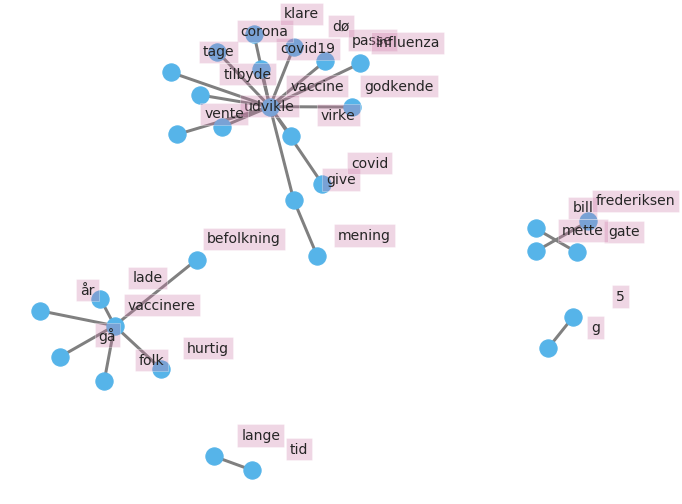

In [46]:
palette = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Create dictionary of bigrams and their counts
d = bigram_df.set_index("bigram").T.to_dict("records")
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 5))

fig, ax = plt.subplots(figsize=(11, 9))

pos = nx.spring_layout(G, k=5)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=10,
                 width=3,
                 edge_color= "grey",#palette[0], #'red',
                 node_color= palette[2], #'green',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.065
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor= palette[7], #'red', 
                      alpha=0.3), ## 0.5),
            horizontalalignment='center', fontsize=14)
    

fig.patch.set_visible(False)
ax.axis('off')

plt.savefig("fig/bigram_graph.png", dpi=150)

plt.show()

## Ngrams with emojis? :) 

In [66]:
def extract_emoji(string):
    string = string["text"]
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    res = re.findall(emoji_pattern, string)
    #res = " ".join(res)
    return res

In [67]:
freq_df["emojis_list"] = freq_df.apply(lambda row: extract_emoji(row), axis = 1)

In [68]:
freq_df.iloc[11535].emojis_list

[]

In [69]:
emojis = freq_df[freq_df["emojis_list"] != []]

ValueError: ('Lengths must match to compare', (44786,), (0,))

In [65]:
# Create list of lists containing bigrams in tweets
#terms_bigram = list(bigrams(wordlist))
terms_bigram = [list(bigrams(tweet)) for tweet in freq_df['emojis_list']]
#terms_bigram = [list(bigrams(tweet)) for tweet in df['tokens_no_stop']]

# View bigrams for the first tweet
terms_bigram[0]

NameError: name 'bigrams' is not defined